# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)




In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os
import os.path
import configparser
import sys
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

In [3]:
def rm_mrr(Lambda): #McClintock relation
    X_piv, z_piv = 40., 0.35
    A0, B0, C0, Z0 = 14.489,  1.356, -0.30, 0.275
    return (10.**A0) * ((Lambda/ X_piv)**B0)  * (((1+Z0) / (1+z_piv)) **(C0))
def criticaldens(z): # Critical density function  
    from astropy import units as u
    SolarM = u.Msun # solar masses
    kpc3 = u.kpc * u.kpc * u.kpc # Mpc^3
    Conv_factor = SolarM / kpc3
    rhoc_ = cosmo.critical_density(z)
    rhoc = rhoc_.to(Conv_factor)
    return rhoc

### ICL jacknife profiles subtraction

In [4]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']
numflag = 0
flagrmem = ['', '_rmem_rlambda','_rmem_r200', '_rmem_scaled','_2cuts', '_2cuts_r200'][numflag]

In [5]:
flagrmem

''

In [6]:
def luptonmags(flux, sigma_):
    ##########################
    ## computing luptitudes ##
    ##########################
    
    m0 = 30.
    f0 = 10.**(m0/2.5)

    a =  2.5*np.log10(np.e) #1.08574
    sigma = sigma_/f0
    b = np.sqrt(a)*sigma
    b_ = f0 * b

    x = flux/f0 

    #mu = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(flux/ (2.*b_) )
    mu0 = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(0/ (2.*b_) ) # for this eq. flux=0.
    mu = mu0 - a * np.arcsinh(flux/ (2.*b_) ) 
        
    var_mag_unc = ( (a)**2 * (sigma_)**2 ) / ( 4*(b_)**2 + (flux)**2) 
    mag_unc = np.sqrt( var_mag_unc )
    
    return mu, mag_unc
#mu, mag_unc = luptonmags(mea, std)
#plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
#plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


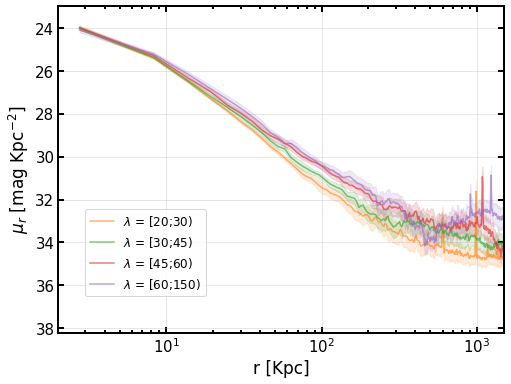

In [7]:
if numflag != 4 and numflag != 5:
    fig = plt.figure(figsize=(8,6))  
    ax = plt.subplot()
    plt.xscale('log')

    plt.grid(alpha=0.4)


    colors = ['C2','C1','C3','C4']

    for i in range(4):



        ngal_bins=i+1
        richness_dir = ['richness_20_30/',
                        'richness_30_45/',
                        'richness_45_60/',
                        'richness_60_beyond/']
        str_ngals = ['$\lambda$ = [20;30)',
                     '$\lambda$ = [30;45)',
                     '$\lambda$ = [45;60)',
                     '$\lambda$ = [60;150)']
        dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]

        dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
        jacknife_profile=np.loadtxt(dir_ind+'sub_moments_uprmem%s.txt'%(flagrmem))
        r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

        mu, mag_unc = luptonmags(mea, std)
        
        plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
        plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')



    plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
    plt.xlabel('r [Kpc]', fontsize=17)

    plt.xticks(fontsize = 0)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(38.2,23)
    plt.xlim(2,1500)

    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)
    
    #plt.savefig(save_dir_rdmp+'paper_figures/'+'mag_rmem_high_lup.png', format='png', dpi=300)
    plt.show()
    ##############################################################################


52.57 Kpc
262.84 Kpc
 
62.89 Kpc
314.44 Kpc
 
73.42 Kpc
367.12 Kpc
 
91.14 Kpc
455.68 Kpc
 


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


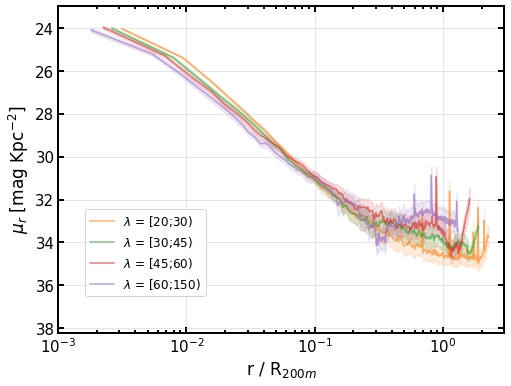

In [8]:
if numflag != 4 and numflag != 5:
    fig = plt.figure(figsize=(8,6))  
    ax = plt.subplot()
    plt.xscale('log')

    plt.grid(alpha=0.4)


    colors = ['C2','C1','C3','C4']

    for i in range(4):



        ngal_bins=i+1
        richness_dir = ['richness_20_30/',
                        'richness_30_45/',
                        'richness_45_60/',
                        'richness_60_beyond/']
        str_ngals = ['$\lambda$ = [20;30)',
                     '$\lambda$ = [30;45)',
                     '$\lambda$ = [45;60)',
                     '$\lambda$ = [60;150)']
        dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]

        dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
        jacknife_profile=np.loadtxt(dir_ind+'sub_moments_uprmem%s.txt'%(flagrmem))
        r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

        # clusters: m200 and r200
        lambdamean = [24.061209, 35.77201, 50.39139, 81.282715]
        lambda_= lambdamean[i]
        m200m = rm_mrr(np.array(lambda_))  
        rhoc = criticaldens(0.275)        
        rhoc_prop = rhoc  #* (cosmo.h**2)
        rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
        r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  


        print('%.2f Kpc'%(r200m*0.06).value)
        print('%.2f Kpc'%(r200m*0.3).value)
        print(' ')


        mu, mag_unc = luptonmags(mea, std)
        
        plt.plot(r_red/r200m, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
        plt.fill_between(r_red/r200m, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')



    plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)

    plt.xticks(fontsize = 0)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(38.2,23)
    plt.xlim(0.001,3)
    plt.xlabel('r / R$_{200m}$', fontsize=17)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)
    
    #plt.savefig(save_dir_rdmp+'paper_figures/'+'scaled_mag_rmem_high_lup.png', format='png', dpi=300)
    plt.show()
    ##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


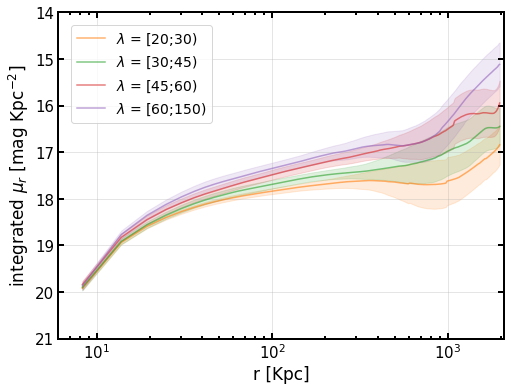

In [9]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):



    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]


    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

    jacknife_profile=np.loadtxt(dir_ind+'int_moments_uprmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
plt.xticks(fontsize = 0)
plt.ylim(21,14)
plt.xlim(6,2100)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)

plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

#plt.savefig(save_dir_rdmp+'paper_figures/'+'int_mag_rmem_high_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

### CENT RMEM clusters

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


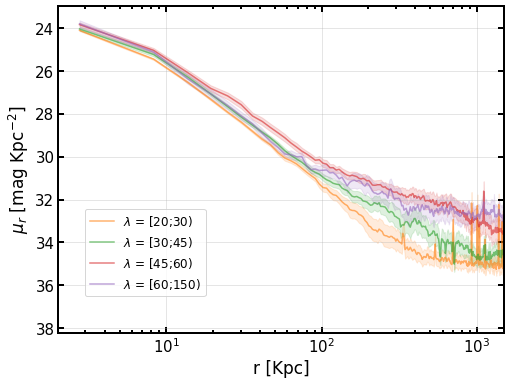

In [35]:
if numflag != 4:

    fig = plt.figure(figsize=(8,6))  
    ax = plt.subplot()
    plt.xscale('log')

    plt.grid(alpha=0.4)


    colors = ['C2','C1','C3','C4']


    for i in range(4):



        ngal_bins=i+1
        richness_dir = ['richness_20_30/',
                        'richness_30_45/',
                        'richness_45_60/',
                        'richness_60_beyond/']
        dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]

        dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
        jacknife_profile=np.loadtxt(dir_ind+'sub_moments_cenrmem%s.txt'%(flagrmem))
        r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

        mu, mag_unc = luptonmags(mea, std)
        
        plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
        plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')



    plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
    plt.xlabel('r [Kpc]', fontsize=17)

    plt.xticks(fontsize = 0)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(38.2,23)
    plt.xlim(2,1500)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

    plt.show()
    ##############################################################################

In [37]:
if numflag != 4:

    from matplotlib import gridspec
    fig = plt.figure(figsize=(8,6))  
    ax = plt.subplot()
    plt.xscale('log')

    plt.grid(alpha=0.4)


    colors = ['C2','C1','C3','C4']


    for i in range(4):



        ngal_bins=i+1
        richness_dir = ['richness_20_30/',
                        'richness_30_45/',
                        'richness_45_60/',
                        'richness_60_beyond/']
        dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]


        dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]

        jacknife_profile=np.loadtxt(dir_ind+'int_moments_cenrmem%s.txt'%(flagrmem))
        r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

        mu, mag_unc = luptonmags(mea, std)

        plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
        plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

    plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
    plt.xlabel('r [Kpc]', fontsize=17)
    plt.xticks(fontsize = 0)
    plt.ylim(21,14)
    plt.xlim(6,2100)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

    plt.show()
    ##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### SMALL RMEM clusters

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


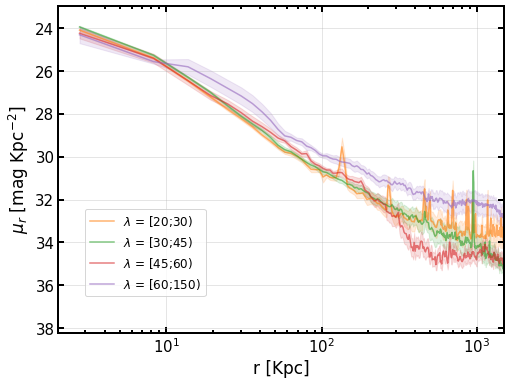

In [40]:

fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_lowrmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')



plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(2,1500)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

#plt.savefig(save_dir_rdmp+'paper_figures/'+'mag_rmem_low_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


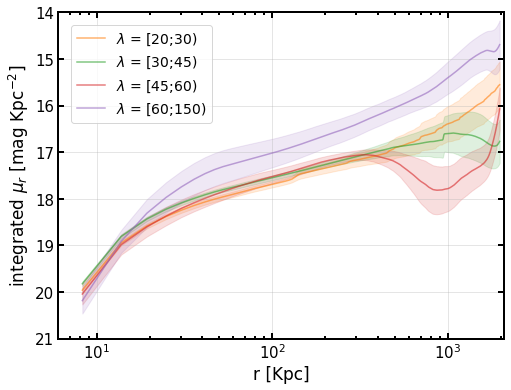

In [41]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_lowrmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
plt.xticks(fontsize = 0)
plt.ylim(21,14)
plt.xlim(6,2100)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

#plt.savefig(save_dir_rdmp+'paper_figures/'+'int_mag_rmem_low_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

In [13]:
from matplotlib import gridspec
fig = plt.figure(figsize=(9,7))  
ax1 = plt.subplot(2,2,1)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_uprmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=0)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=0)
plt.ylim(38.2,23)
plt.xlim(6,2000)
[ax1.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    
plt.legend(bbox_to_anchor=(0.03, 0.48),  loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
plt.subplots_adjust(wspace=0, hspace=0)

##############################################################################




ax2 = plt.subplot(2,2,2)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments_lowrmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=0)
plt.xlabel('r [Kpc]', fontsize=0)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=0)
plt.xticks(fontsize=0)
plt.ylim(38.2,23)
plt.xlim(6,2000)
[ax2.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    
plt.legend(bbox_to_anchor=(0.03, 0.48),  loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
plt.subplots_adjust(wspace=0, hspace=0)

##############################################################################


ax3 = plt.subplot(2,2,3)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_uprmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(21,14)
plt.xlim(6,2000)
[ax3.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    
plt.legend(bbox_to_anchor=(0.03, 0.99),  loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
plt.subplots_adjust(wspace=0, hspace=0)

##############################################################################








ax4 = plt.subplot(2,2,4)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_lowrmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=0)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=0)
plt.xticks(fontsize=15)
plt.ylim(21,14)
plt.xlim(6,2000)
[ax4.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]

    
plt.legend(bbox_to_anchor=(0.03, 0.99),  loc=2, fontsize=10,borderaxespad=0.,numpoints=1,scatterpoints=1)
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(save_dir_rdmp+'paper_figures/'+'rmem_high_low_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [59]:
from matplotlib import gridspec
fig = plt.figure(figsize=(7,12))  
ax = plt.subplot(2,1,1)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_uprmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    
    
plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
if flagrmem == '_rmem_scaled':
    plt.xlabel('r / R$_{200m}$', fontsize=17)
plt.xticks(fontsize = 0)
plt.ylim(21,14)
plt.xlim(6,2000)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

##############################################################################


ax0 = plt.subplot(2,1,2)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C2','C1','C3','C4']


for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_lowrmem%s.txt'%(flagrmem))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')

plt.ylabel('integrated $\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)
plt.xticks(fontsize = 0)
plt.ylim(21,14)
plt.xlim(6,2000)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
[ax0.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]

    
plt.legend(bbox_to_anchor=(0.03, 0.96), loc=2, fontsize=14,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.savefig(save_dir_rdmp+'paper_figures/'+'int_mag_rmem_high_low_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Comparison small and large

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

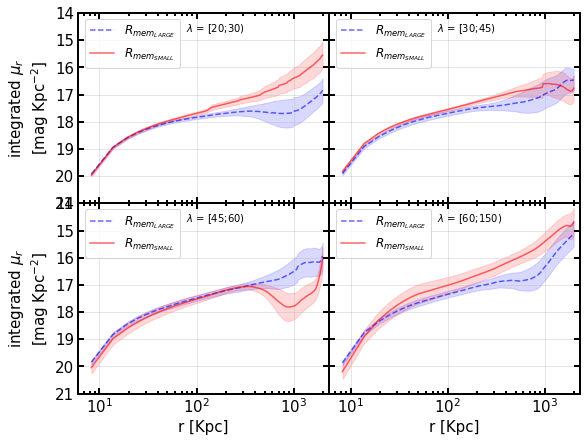

In [12]:

fig = plt.figure(figsize=(9,7))  


for i in range(4):
    
    ax = plt.subplot(2,2,i+1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid(alpha=0.4)
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    
   
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_uprmem.txt')
    r_red0, mea0, std0 = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu0, mag_unc0 = luptonmags(mea0, std0)

    plt.plot(r_red0, mu0, '--', lw=1.5,alpha=0.6,color='blue',label='$R_{mem_{LARGE}}$')
    plt.fill_between(r_red0, mu0 + mag_unc0, mu0 - mag_unc0, color='blue', alpha=0.15, label='')
    
    
    
    jacknife_profile=np.loadtxt(dir_ind+'int_moments_lowrmem.txt')
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
    
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color='red',label='$R_{mem_{SMALL}}$')
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color='red', alpha=0.15, label='')


    plt.ylim(21,14)
    plt.xlim(6, 2.3e3)
    plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=1.,
                   bottom='on', top='on', left='on', right ='on')
    plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=13.,
                   bottom='on', top='on', left='on', right ='on')
    plt.yticks(fontsize=0)
    plt.xticks(fontsize=0)
    [ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.legend(bbox_to_anchor=(0.03, 0.97),  loc=2, fontsize=12,borderaxespad=0.,
               numpoints=1,scatterpoints=1)
    
    plt.annotate(str_ngals[i],
                 xy=(0.43,0.9),xycoords='axes fraction',
                 fontsize=10)


plt.subplot(2,2,1)  
plt.ylabel('integrated $\mu_{r}$ \n'+'[mag Kpc$^{-2}$]', fontsize=15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,3)  
plt.xlabel('r [Kpc]', fontsize=15)
plt.ylabel('integrated $\mu_{r}$ \n'+'[mag Kpc$^{-2}$]', fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.subplot(2,2,4)  
plt.xlabel('r [Kpc]', fontsize=15) 
plt.xticks(fontsize = 15)
    
plt.savefig(save_dir_rdmp+'paper_figures/'+'int_mag_rmem_lup.png', format='png', dpi=300)
plt.show()
##############################################################################